In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold

np.random.seed(1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Measuring the Applicants Gap (dropped schools)

This kernel is a complement to [Measuring the Applicants Gap in 2017
][1].

There, we predicted the so called applicants gap by fitting a logistic regression over all the variables we had.

We will do the same thing here, but, instead of using all variables, we will use just the variables that are available to some schools (the schools that were dropped in the previous kernel!).

*As most of what is happening is in the code, you can skip this if you like.*

[1]: https://www.kaggle.com/araraonline/measuring-the-applicants-gap-in-2017

# Prepare the data

In [3]:
df = pd.read_pickle('../data/process/schools2017.pkl')
todrop = df[df['School Name'].isnull()]
print(df.shape[0], "schools")

# drop schools
df = df[df['School Name'].notnull()]
print(df.shape[0], "schools")

# prepare variables
bad_ela = df[df['Mean Scale Score - ELA'].isnull()]
bad_math = df[df['Mean Scale Score - Math'].isnull()]
bad_presence = df[df['Percent of Students Chronically Absent'].isnull()]

df.head()

594 schools
592 schools


,School Name,Charter School?,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,# SHSAT Testers,# SHSAT Offers,% SHSAT Testers,% SHSAT Offers
DBN,,,,,,,,,,,,,,,,,,,,,,,,,,,
01M034,P.S. 034 Franklin D. Roosevelt,0.0,manhattan,40.726008,-73.975058,0.053,0.297,0.614,0.030,0.006,0.080,0.380,0.305,0.872,-0.114090,0.592593,0.222222,0.018519,-0.699534,0.346154,0.134615,0.000000,58.0,6.0,NaN,0.103448,NaN
01M140,P.S. 140 Nathan Straus,0.0,manhattan,40.719148,-73.983769,0.044,0.121,0.794,0.030,0.011,0.124,0.338,0.395,0.853,-0.161186,0.600000,0.218182,0.018182,-0.454722,0.385965,0.140351,0.000000,67.0,6.0,NaN,0.089552,NaN
01M184,P.S. 184m Shuang Wen,0.0,manhattan,40.711125,-73.985438,0.697,0.044,0.124,0.085,0.050,0.171,0.192,0.041,0.560,1.708300,0.209876,0.395062,0.345679,1.781980,0.168675,0.289157,0.445783,88.0,67.0,23.0,0.761364,0.261364
01M188,P.S. 188 The Island School,0.0,manhattan,40.719888,-73.977380,0.019,0.320,0.625,0.036,0.000,0.154,0.332,0.369,0.938,-0.263454,0.450980,0.156863,0.019608,-0.304492,0.461538,0.211538,0.000000,59.0,NaN,NaN,NaN,NaN
01M301,"Technology, Arts, and Sciences Studio",0.0,manhattan,40.730009,-73.984496,0.087,0.323,0.496,0.055,0.039,0.047,0.441,0.382,0.746,0.253700,0.463415,0.317073,0.048780,-0.595540,0.365854,0.121951,0.024390,51.0,11.0,NaN,0.215686,NaN


There are two schools that have almost no information, so we dropped them nevertheless. Here they are:

In [4]:
todrop

,School Name,Charter School?,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,# SHSAT Testers,# SHSAT Offers,% SHSAT Testers,% SHSAT Offers
DBN,,,,,,,,,,,,,,,,,,,,,,,,,,,
07X584,NaN,NaN,bronx,40.814857,-73.912038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,10.0,NaN,0.09434,NaN
84M337,NaN,NaN,manhattan,40.785559,-73.940919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Create models

We will create 3 models, one for each type of variable missing.

CV and model fitting is performed just like the previous kernel did.

In [5]:
# cross-validation utils

def cross_validate(inputs, outputs):
    # drop rows with NaN
    inputs = inputs[
        inputs.notnull().all(axis=1) &
        outputs.notnull()
    ]
    outputs = outputs.reindex(inputs.index)
    
    # cross-validation
    cv_results = []
    n_splits = 10
    n_repeats = 20
    for n_components in range(1, inputs.shape[1] + 1):
        mae_scores = []
        mse_scores = []

        x = PCA(n_components).fit_transform(inputs)
        x = pd.DataFrame(x, index=inputs.index, columns=["PC{}".format(i) for i in range(1, n_components + 1)])
        x['Constant'] = 1
        y = outputs.copy()


        cv = RepeatedKFold(n_splits, n_repeats, random_state=1)    
        for train, test in cv.split(x):
            x_train = x.iloc[train]
            x_test = x.iloc[test]
            y_train = y.iloc[train]
            y_test = y.iloc[test]

            model = sm.RLM(y_train, x_train)
            results = model.fit()
            predictions = model.predict(results.params, exog=x_test)
            mae = median_absolute_error(y_test, predictions)
            mse = mean_squared_error(y_test, predictions)
            mae_scores.append(mae)
            mse_scores.append(mse)

        mae_scores = np.array(mae_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
        mse_scores = np.array(mse_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat

        mae_mean = np.mean(mae_scores)
        mae_std = np.std(mae_scores)
        mse_mean = np.mean(mse_scores)
        mse_std = np.std(mse_scores)

        cv_result = (n_components, mae_mean, mse_mean, mae_std, mse_std)
        cv_results.append(cv_result)

    df_columns = ['n_components', 'mae__mean', 'mse__mean', 'mae__std', 'mse__std']
    cv_results_df = pd.DataFrame(cv_results, columns=df_columns)
    return cv_results_df

def visualize_cv(df):
    plt.figure()
    plt.errorbar(df.n_components, df.mae__mean, df.mae__std, marker='o', label='Median Absolute Error')
    plt.legend()

    plt.figure()
    plt.errorbar(df.n_components, df.mse__mean, df.mse__std, marker='o', label='Mean Squared Error')
    plt.legend();

## Model 1 - Missing presence information

In [6]:
target_rows = df.loc[
    df['School Name'].notnull() &
    df['Mean Scale Score - ELA'].notnull() &
    df['Mean Scale Score - Math'].notnull() &
    df['Percent of Students Chronically Absent'].isnull()    
]

explan_variables = [
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
#     'Percent of Students Chronically Absent',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math', 
]

# fit values
inputs = df[explan_variables]
outputs = logit(df['% SHSAT Testers'])

nanrows = inputs.isnull().any(axis=1)
inputs = inputs[~nanrows]
outputs = outputs[~nanrows]

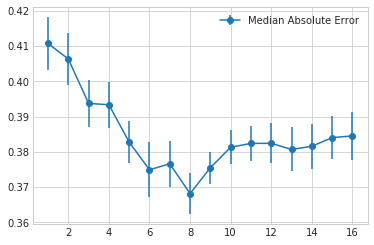

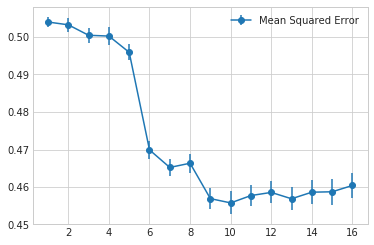

In [7]:
cvdf = cross_validate(inputs, outputs)
visualize_cv(cvdf)

In [8]:
def prepare_inputs(df):    
    n_components = 8
    columns = ["PC{}".format(i+1) for i in range(n_components)]
    
    # PCA
    pca = PCA(n_components)
    transformed = pca.fit_transform(df)
    transformed = pd.DataFrame(transformed, index=df.index, columns=columns)

    # aditional column
    inputs = transformed
    inputs.insert(0, 'Constant', 1.0)
    
    return inputs

model = sm.RLM(outputs, prepare_inputs(inputs), missing='drop')
results = model.fit()
predictions = model.predict(results.params, exog=prepare_inputs(inputs))
predictions = pd.Series(predictions, index=inputs.index)

In [9]:
_outputs = outputs.dropna()
_predictions = predictions.reindex(_outputs.index)

mae = median_absolute_error(_outputs, _predictions)
mse = mean_squared_error(_outputs, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.3574112014529469
Mean Squared Error: 0.45075908029684647


In [10]:
predictions1 = predictions.reindex(target_rows.index)

## Model 2 - No NYS Math information

In [11]:
target_rows = df.loc[
    df['School Name'].notnull() &
    df['Mean Scale Score - ELA'].notnull() &
    df['Mean Scale Score - Math'].isnull() &
    df['Percent of Students Chronically Absent'].notnull()    
]

explan_variables = [
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    'Percent of Students Chronically Absent',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
#     'Mean Scale Score - Math',
#     '% Level 2 - Math',
#     '% Level 3 - Math',
#     '% Level 4 - Math', 
]

# fit values
inputs = df[explan_variables]
outputs = logit(df['% SHSAT Testers'])

nanrows = inputs.isnull().any(axis=1)
inputs = inputs[~nanrows]
outputs = outputs[~nanrows]

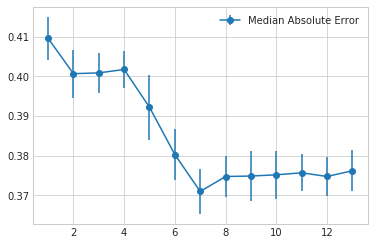

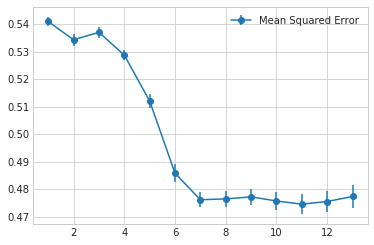

In [12]:
cvdf = cross_validate(inputs, outputs)
visualize_cv(cvdf)

In [13]:
def prepare_inputs(df):    
    n_components = 7
    columns = ["PC{}".format(i+1) for i in range(n_components)]
    
    # PCA
    pca = PCA(n_components)
    transformed = pca.fit_transform(df)
    transformed = pd.DataFrame(transformed, index=df.index, columns=columns)

    # aditional column
    inputs = transformed
    inputs.insert(0, 'Constant', 1.0)
    
    return inputs

model = sm.RLM(outputs, prepare_inputs(inputs), missing='drop')
results = model.fit()
predictions = model.predict(results.params, exog=prepare_inputs(inputs))
predictions = pd.Series(predictions, index=inputs.index)

In [14]:
_outputs = outputs.dropna()
_predictions = predictions.reindex(_outputs.index)

mae = median_absolute_error(_outputs, _predictions)
mse = mean_squared_error(_outputs, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.3686692307441025
Mean Squared Error: 0.46005710406564015


In [15]:
predictions2 = predictions.reindex(target_rows.index)

## Model 3 - No NYS ELA or Math information

In [16]:
target_rows = df.loc[
    df['School Name'].notnull() &
    df['Mean Scale Score - ELA'].isnull() &
    df['Mean Scale Score - Math'].isnull() &
    df['Percent of Students Chronically Absent'].notnull()    
]

explan_variables = [
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    'Percent of Students Chronically Absent',
    
#     'Mean Scale Score - ELA',
#     '% Level 2 - ELA',
#     '% Level 3 - ELA',
#     '% Level 4 - ELA',
#     'Mean Scale Score - Math',
#     '% Level 2 - Math',
#     '% Level 3 - Math',
#     '% Level 4 - Math', 
]

# fit values
inputs = df[explan_variables]
outputs = logit(df['% SHSAT Testers'])

nanrows = inputs.isnull().any(axis=1)
inputs = inputs[~nanrows]
outputs = outputs[~nanrows]

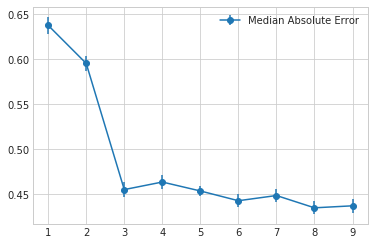

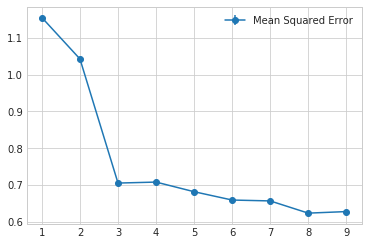

In [17]:
cvdf = cross_validate(inputs, outputs)
visualize_cv(cvdf)

In [18]:
def prepare_inputs(df):    
    n_components = 6
    columns = ["PC{}".format(i+1) for i in range(n_components)]
    
    # PCA
    pca = PCA(n_components)
    transformed = pca.fit_transform(df)
    transformed = pd.DataFrame(transformed, index=df.index, columns=columns)

    # aditional column
    inputs = transformed
    inputs.insert(0, 'Constant', 1.0)
    
    return inputs

model = sm.RLM(outputs, prepare_inputs(inputs), missing='drop')
results = model.fit()
predictions = model.predict(results.params, exog=prepare_inputs(inputs))
predictions = pd.Series(predictions, index=inputs.index)

In [19]:
_outputs = outputs.dropna()
_predictions = predictions.reindex(_outputs.index)

mae = median_absolute_error(_outputs, _predictions)
mse = mean_squared_error(_outputs, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.4360797441234512
Mean Squared Error: 0.6454383246352793


In [20]:
predictions3 = predictions.reindex(target_rows.index)

# Results

The prediction scores were expected to drop some, and they did. We will use all the information we have though. Glueing the results together:

In [28]:
predictions = pd.concat([
    predictions1,
    predictions2,
    predictions3
])
predictions = expit(predictions)  # convert logits to percentages
predictions.name = 'Expected % of SHSAT Testers'

Exporting results for the public:

In [27]:
df_export = predictions.to_frame()
# df_export.to_csv("expected_testers.csv")

print(df_export.shape[0], "schools")
df_export.head()

14 schools


,Expected % of SHSAT Testers
DBN,
84K780,0.337216
84K803,0.292897
84M351,0.637285
84M384,0.709677
84M385,0.613808
